In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from shapely.geometry import Point,Polygon

track_left = pd.read_csv("Track_Left.xlsx") # or f1sim-ref-left.csv which was given initially
track_right = pd.read_csv("Track_Left.xlsx") # or f1sim-ref-right.csv
# track_line = pd.read_csv("Data3001G2/data/f1sim-ref-line.csv") add this if you have the file (its not on github but came from same place as the above two)

track_poly = Polygon(
    np.vstack([
        track_left[['WORLDPOSX', 'WORLDPOSY']].values,
        track_right[['WORLDPOSX', 'WORLDPOSY']].values[::-1]
    ])
)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns[1:])
y_scaled_df = pd.DataFrame(y_scaled, columns=["Target_CURRENTLAPTIMEINMS"])

x_cols = sorted([c for c in X_scaled_df.columns if "WORLDPOSITIONX" in c])
y_cols = sorted([c for c in X_scaled_df.columns if "WORLDPOSITIONY" in c])

def sampling(bounds, N, rng, x_cols, y_cols):
    xy_pairs = list(zip(x_cols, y_cols))
    valid = []

    while len(valid) < N:
        cand_idx = rng.integers(0, len(X_scaled_df))
        cand = X_scaled_df.iloc[cand_idx].to_dict()

        all_inside = True
        for xc, yc in xy_pairs:
            x = cand[xc]
            y = cand[yc]

            if not track_poly.contains(Point(x, y)):
                all_inside = False
                break
        if all_inside:
            valid.append(cand)
    return pd.DataFrame(valid)

In [ ]:
percentiles = (0.0000001, 0.999999)

bounds = {
    f: (X_scaled_df[f].quantile(percentiles[0]),
        X_scaled_df[f].quantile(percentiles[1]))
    for f in X_scaled_df.columns
}

rng = np.random.default_rng(42)
N = 5000

Xcand = sampling(bounds, N, rng, x_cols, y_cols)
Xcand = Xcand[X_scaled_df.columns]

ycand = grid_poly.predict(Xcand)
ycand_unscaled = scaler_y.inverse_transform(ycand.reshape(-1, 1)).ravel()

imin = int(np.argmin(ycand_unscaled))
best_combo_scaled = Xcand.iloc[imin].to_frame().T
best_combo_unscaled = pd.DataFrame(
    scaler_X.inverse_transform(best_combo_scaled),
    columns=X.columns[1:]
)

best_pred = ycand_unscaled[imin]

print("\n=== SVR-suggested first-brake setup (within observed range) ===")
for k, v in best_combo_unscaled.iloc[0].items():
    print(f"{k}: {v:,.4f}")
print(f"Predicted Target_CURRENTLAPTIMEINMS: {best_pred:,.3f}")


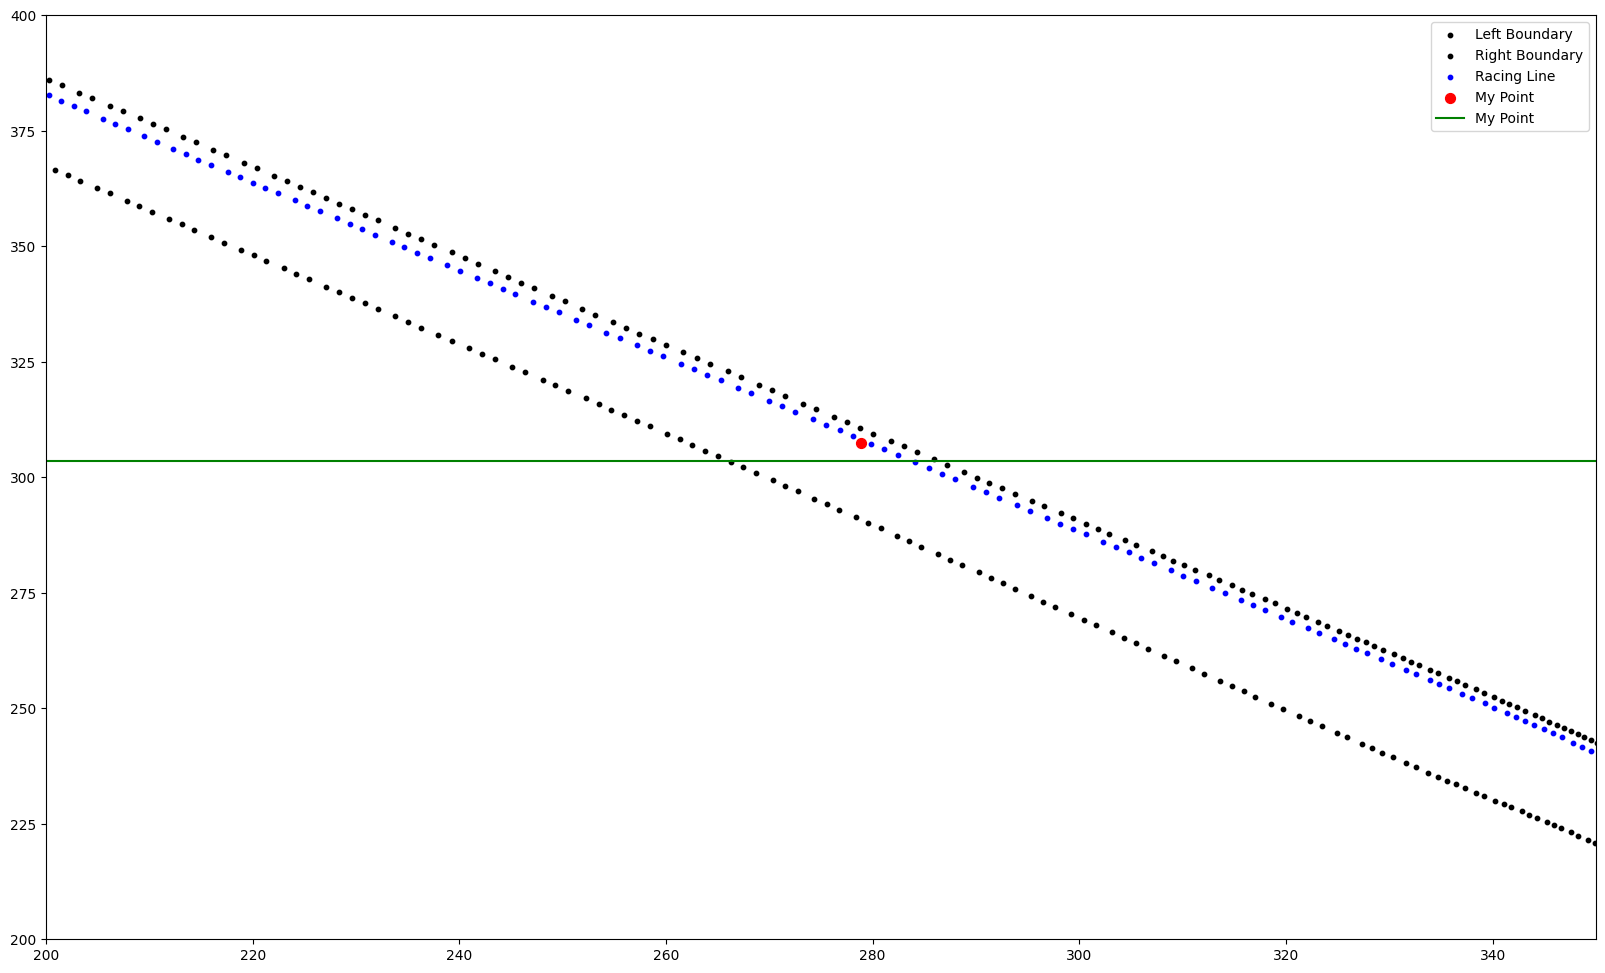

In [ ]:
import matplotlib.pyplot as plt

points = {}

prefixes = ["BPS", "BPE", "THS", "THE", "STS", "STM", "STE", "APX1", "APX2"]

row = best_combo_unscaled.iloc[0]
for p in prefixes:
    x_col = f"{p}_WORLDPOSITIONX"
    y_col = f"{p}_WORLDPOSITIONY"
    
    if x_col in row and y_col in row:
        points[p] = (float(row[x_col]), float(row[y_col]))

plt.figure(figsize=(10, 8))
f = 100000
# Track boundaries/centerline
plt.scatter(track_left.loc[track_left["FRAME"] <= f,  "WORLDPOSX"],
            track_left.loc[track_left["FRAME"] <= f,  "WORLDPOSY"],
            s=2, color="black", label="Track Left")
plt.scatter(track_right.loc[track_right["FRAME"] <= f, "WORLDPOSX"],
            track_right.loc[track_right["FRAME"] <= f, "WORLDPOSY"],
            s=2, color="black", label="Track Right")
# plt.scatter(track_line.loc[track_line["FRAME"] <= f,  "WORLDPOSX"],
#             track_line.loc[track_line["FRAME"] <= f,  "WORLDPOSY"],
#             s=2, color="gray",  label="Track Line")

# Plot setup
for name, (x, y) in points.items():
    plt.scatter(x, y, s=50, label=name)
    plt.text(x + 1.5, y + 1.5, name, fontsize=12, weight="bold")

# Styling
plt.xlabel("WORLD POSITION X", fontsize=12)
plt.ylabel("WORLD POSITION Y", fontsize=12)
plt.title("World Position of Critical Moments", fontsize=14, pad=15)
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(275, 475)
plt.ylim(-50, 400)
plt.show()
